# Programming Exercise 7:
# K-means Clustering and Principal Component Analysis

## Introduction

In this exercise, you will implement the K-means clustering algorithm and apply it to compress an image. In the second part, you will use principal component analysis to find a low-dimensional representation of face images. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook. The assignment can be promptly submitted to the coursera grader directly from this notebook (code and instructions are included below).

Before we begin with the exercises, we need to import all libraries required for this programming exercise. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, [`matplotlib`](https://matplotlib.org/) for plotting, and [`scipy`](https://docs.scipy.org/doc/scipy/reference/) for scientific and numerical computation functions and tools.

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import optimize
try:
    plt.rcParams["animation.html"] = "jshtml"
except ValueError:
    plt.rcParams["animation.html"] = "html5"

## 1 K-means Clustering

In this exercise, you will implement K-means algorithm and use it for image compression. You will first start on an example 2D dataset that will help you gain an intuition of how the K-means algorithm works. After
that, you wil use the K-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are most common in that image.

### 1.1 Implementing K-means

The K-means algorithm is a method to automatically cluster similar data examples together. Concretely, you are given a training set $\{x^{(1)} , \cdots, x^{(m)}\}$ (where $x^{(i)} \in \mathbb{R}^n$), and want to group the data into a few cohesive “clusters”. The intuition behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

The K-means algorithm is as follows:

```python
centroids = k_means_init_centroids(X, K)
for i in range(iterations):
    # Cluster assignment step: Assign each data point to the
    # closest centroid. idx[i] corresponds to cˆ(i), the index
    # of the centroid assigned to example i
    idx = find_closest_centroids(X, centroids)
    
    # Move centroid step: Compute means based on centroid
    # assignments
    centroids = compute_means(X, idx, K)
```

The inner-loop of the algorithm repeatedly carries out two steps: (1) Assigning each training example $x^{(i)}$ to its closest centroid, and (2) Recomputing the mean of each centroid using the points assigned to it. The K-means algorithm will always converge to some final set of means for the centroids. Note that the converged solution may not always be ideal and depends on the initial setting of the centroids. Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion). You will implement the two phases of the K-means algorithm separately
in the next sections.

#### 1.1.1 Finding closest centroids

In the “cluster assignment” phase of the K-means algorithm, the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current positions of centroids. Specifically, for every example $i$ we set

$$c^{(i)} := j \quad \text{that minimizes} \quad \lvert\rvert x^{(i)} - \mu_j  \lvert\rvert^2, $$

where $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_j$ is the position (value) of the $j^{th}$ centroid. Note that $c^{(i)}$ corresponds to `idx[i]` in the starter code.

Your task is to complete the code in the function `find_closest_centroids`. This function takes the data matrix `X` and the locations of all centroids inside `centroids` and should output a one-dimensional array `idx` that holds the index (a value in $\{1, ..., K\}$, where $K$ is total number of centroids) of the closest centroid to every training example.

You can implement this using a loop over every training example and every centroid.

In [5]:
def find_closest_centroids(X, centroids):
    """
    Computes the centroid memberships for every example.
    
    Parameters
    ----------
    X : array_like
        The dataset of size (m, n) where each row is a single example. 
        That is, we have m examples each of n dimensions.
        
    centroids : array_like
        The k-means centroids of size (K, n). K is the number
        of clusters, and n is the the data dimension.
    
    Returns
    -------
    idx : array_like
        A vector of size (m, ) which holds the centroids assignment for each
        example (row) in the dataset X.
    
    Instructions
    ------------
    Go over every example, find its closest centroid, and store
    the index inside `idx` at the appropriate location.
    Concretely, idx[i] should contain the index of the centroid
    closest to example i. Hence, it should be a value in the 
    range 0..K-1

    Note
    ----
    You can use a for-loop over the examples to compute this.
    """
    # Set K
    K = centroids.shape[0]

    # You need to return the following variables correctly.
    idx = np.zeros(X.shape[0], dtype=int)

    for i in np.arange(idx.size):
        
        J = np.sqrt(np.sum(np.square(X[i] - centroids), axis = 1))
            
        idx[i] = np.argmin(J)
    
    return idx

Once you have completed the code in `find_closest_centroids`, the following cell will run your code and you should see the output `[0 2 1]` corresponding to the centroid assignments for the first 3 examples.

In [7]:
# Load an example dataset that we will be using
data = loadmat("Data/ex7data2.mat")
X = data['X']
# Select an initial set of centroids
K = 3   # 3 Centroids
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])
# Find the closest centroids for the examples using the initial_centroids
idx = find_closest_centroids(X, initial_centroids)

print('Closest centroids for the first 3 examples:')
print(idx[:3])
print('(the closest centroids should be 0, 2, 1 respectively)')

Closest centroids for the first 3 examples:
[0 2 1]
(the closest centroids should be 0, 2, 1 respectively)


In [15]:
initial_centroids.shape

(3, 2)

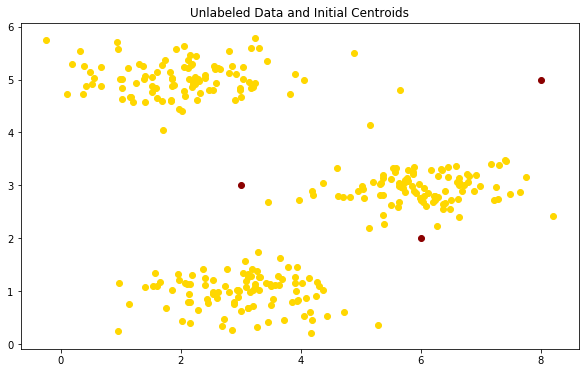

In [30]:
plt.figure(figsize= (10,6))
plt.scatter(X[:,0], X[:,1], c= "gold")
plt.scatter(initial_centroids[:,0], initial_centroids[:,1], c= "darkred")
plt.title("Unlabeled Data and Initial Centroids")
plt.show()

In [50]:
X[200] - initial_centroids

array([[ 3.00506534, -0.27215829],
       [ 0.00506534,  0.72784171],
       [-1.99493466, -2.27215829]])

In [32]:
# test one example with closest centroids
np.argmin(np.sqrt(np.sum(np.square(X[200] - initial_centroids), axis = 1)))

1

### 1.1.2 Computing centroid means

Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid $k$ we set

$$ \mu_k := \frac{1}{\left| C_k\right|} \sum_{i \in C_k} x^{(i)}$$

where $C_k$ is the set of examples that are assigned to centroid $k$. Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k = 2$, then you should update $\mu_2 = \frac{1}{2} \left( x^{(3)} + x^{(5)} \right)$.

You should now complete the code in the function `compute_centroids`. You can implement this function using a loop over the centroids. You can also use a loop over the examples; but if you can use a vectorized implementation that does not use such a loop, your code may run faster.

In [51]:
def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the data points
    assigned to each centroid.
    
    Parameters
    ----------
    X : array_like
        The datset where each row is a single data point. That is, it 
        is a matrix of size (m, n) where there are m datapoints each
        having n dimensions. 
    
    idx : array_like 
        A vector (size m) of centroid assignments (i.e. each entry in range [0 ... K-1])
        for each example.
    
    K : int
        Number of clusters
    
    Returns
    -------
    centroids : array_like
        A matrix of size (K, n) where each row is the mean of the data 
        points assigned to it.
    
    Instructions
    ------------
    Go over every centroid and compute mean of all points that
    belong to it. Concretely, the row vector centroids[i, :]
    should contain the mean of the data points assigned to
    cluster i.

    Note:
    -----
    You can use a for-loop over the centroids to compute this.
    """
    # Useful variables
    m, n = X.shape
    # You need to return the following variables correctly.
    centroids = np.zeros((K, n))

    for i in np.arange(K):
        centroids[i] = np.mean(X[idx == i], axis = 0)
        
    return centroids

Once you have completed the code in `compute_centroids`, the following cell will run your code and output the centroids after the first step of K-means.

In [52]:
# Compute means based on the closest centroids found in the previous part.
centroids = compute_centroids(X, idx, K)

print('Centroids computed after initial finding of closest centroids:')
print(centroids)
print('\nThe centroids should be')
print('   [ 2.428301 3.157924 ]')
print('   [ 5.813503 2.633656 ]')
print('   [ 7.119387 3.616684 ]')

Centroids computed after initial finding of closest centroids:
[[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]

The centroids should be
   [ 2.428301 3.157924 ]
   [ 5.813503 2.633656 ]
   [ 7.119387 3.616684 ]


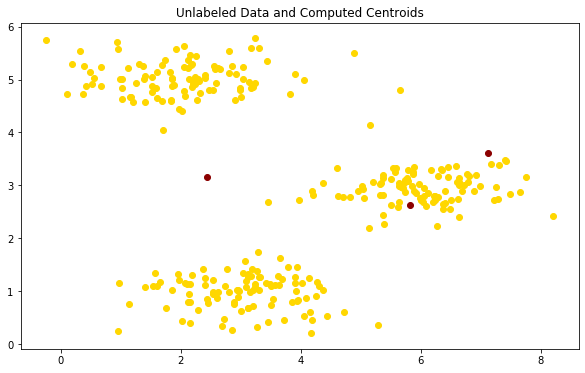

In [54]:
plt.figure(figsize= (10,6))
plt.scatter(X[:,0], X[:,1], c= "gold")
plt.scatter(centroids[:,0], centroids[:,1], c= "darkred")
plt.title("Unlabeled Data and Computed Centroids")
plt.show()